notes on 2020.1.8:
- use linear rain rate instead of dBZ
- add T0 data, which is supposed to be 100% accurate for debugging. The current problem is  it is 0 for sparseSD

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.getcwd())

data_folder = "/Users/jiang/data/radar20190101"

/Users/jiang/github_all/rainymotion/docs/notebooks


In [2]:
from netCDF4 import Dataset
from datetime import datetime,timedelta
from rainymotion import models, metrics, utils
from collections import OrderedDict
import h5py
import wradlib.ipol as ipol


In [3]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
nc_files.sort()

In [4]:
all_data = [] # 288 arrays with shape (1000,1000)
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled()
    all_data.append(rain_filled) 

In [5]:
import skimage.transform as sktf
from rainymotion.models import _sparse_linear,_sparse_sd
transformations = {'euclidean': sktf.EuclideanTransform(),
                   'similarity': sktf.SimilarityTransform(),
                   'affine': sktf.AffineTransform(),
                   'projective': sktf.ProjectiveTransform()}

now = 1
inputs = np.array([all_data[now-1],all_data[now]])
c1 = inputs.min()
c2 = inputs.max()
data_scaled = ((inputs - c1) / (c2 - c1) * 255).astype(np.uint8)

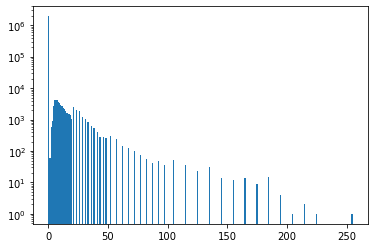

In [8]:
plt.hist(data_scaled.astype('uint8').ravel(),256)
plt.yscale('log')
plt.show()

In [11]:
import cv2
trf = transformations['affine']
of_params = {'st_pars': dict(maxCorners=200, qualityLevel=0.2,
                                          minDistance=7, blockSize=21),
                          'lk_pars': dict(winSize=(20, 20), maxLevel=2,
                                          criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0))}
lead_steps = 13
pts_source, pts_target_container = _sparse_sd(data_instance = data_scaled,
               of_params = of_params, lead_steps = lead_steps) # (128,2),12 elements of (128,2) 


In [13]:
last_frame = data_scaled[-1]
nowcst_frames = []

for lead_step, pts_target in enumerate(pts_target_container):

    # estimate transformation matrix
    # based on source and traget points
    trf.estimate(pts_source, pts_target)

    # make a nowcast
    nowcst_frame = sktf.warp(last_frame/255, trf.inverse)
    # transformations dealing with strange behaviour
    nowcst_frame = (nowcst_frame*255).astype('uint8')
    # add to the container
    nowcst_frames.append(nowcst_frame)

nowcst_frames = np.stack(nowcst_frames, axis=0)

nowcst_frames = (nowcst_frames / 255)*(c2 - c1) + c1

### text single prediction in 5,10,15..60 minutes 

In [5]:
now = 1
threshold = 1  # mm/h
#threshold_5m = threshold / 12
if True: 
    hh = str(now * 5 // 60).zfill(2) 
    mm = str(now * 5  % 60).zfill(2)
    print(f"now = 2019.1.1-{hh}:{mm}")
    
    inputs = np.array([all_data[now-1],all_data[now]])
    
    # SparseSD mode
    model = models.SparseSD()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    sparsecast = nowcast.copy()
    sparse_13_th = []
    sparse_13_re = []
    sparse_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold)
        sparse_13_th.append( hits / (hits + misses + falsealarms))
        sparse_13_re.append( hits / (hits + misses))
        sparse_13_pr.append( hits / (hits + falsealarms))
    
    # Dense mode
    model = models.Dense()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    dense_13_th = []  # threat score
    dense_13_re = []  # recall
    dense_13_pr = []  # precision
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold)
        dense_13_th.append( hits / (hits + misses + falsealarms))
        dense_13_re.append( hits / (hits + misses))
        dense_13_pr.append( hits / (hits + falsealarms))
        #dense_12.append(metrics.CSI(all_data[now+1+i],nowcast[i], threshold = 1))

    # persistance    
    persist_13_th = []
    persist_13_re = []
    persist_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now+i],all_data[now], threshold = threshold)
        persist_13_th.append( hits / (hits + misses + falsealarms))
        persist_13_re.append( hits / (hits + misses))
        persist_13_pr.append( hits / (hits + falsealarms))

    plt.figure(dpi = 100)
    lead_time = list(range(0,65,5))
    plt.plot(lead_time, dense_13_th, '-*', label = "dense")
    plt.plot(lead_time, sparse_13_th, '-s',label = "sparse")
    plt.plot(lead_time, persist_13_th, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("threat score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2019.1.1-{hh}:{mm},rainymotion+opencv,threshold = 1 mm/h")
    plt.grid()
    plt.savefig("JMA_rainymotion_th" + str(now).zfill(3) + ".png",format = "png")
    plt.close()

now = 2019.1.1-00:05
I changed !


/Users/jiang/anaconda3/envs/rainymotion/lib/python3.8/site-packages/wradlib/ipol.py:368: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / self.dists ** self.p


## check data distribution

In [ ]:
all_data[now+i],nowcast[i]

In [11]:
np.sum(all_data[now+i]==0),  np.sum(nowcast[i]==0), np.sum(sparsecast[i]==0)

(973692, 967034, 0)

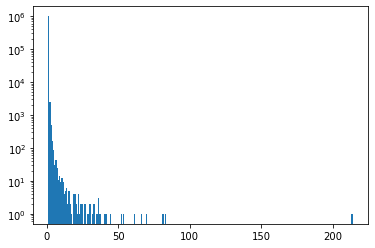

In [12]:
plt.hist(sparsecast[i].ravel(),256)
plt.yscale('log')

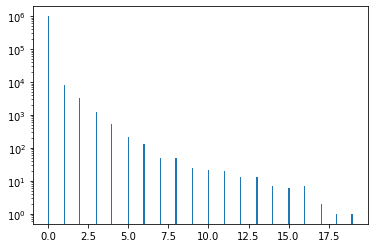

In [18]:
plt.hist(nowcast[i].astype('uint8').ravel(),256)
plt.yscale('log')

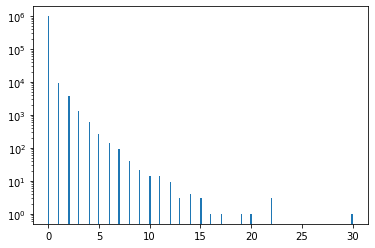

In [19]:
plt.hist(all_data[now+i].astype('uint8').ravel(),256)
plt.yscale('log')

In [13]:
if True: 
    hh = str(now * 5 // 60).zfill(2) 
    mm = str(now * 5  % 60).zfill(2)
    print(f"now = 2019.1.1-{hh}:{mm}")
    
    inputs = np.array([all_data[now-1],all_data[now]])
    
    # SparseSD mode
    model = models.SparseSD()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    sparsecast = nowcast.copy()
    sparse_13_th = []
    sparse_13_re = []
    sparse_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold)
        sparse_13_th.append( hits / (hits + misses + falsealarms))
        sparse_13_re.append( hits / (hits + misses))
        sparse_13_pr.append( hits / (hits + falsealarms))

now = 2019.1.1-00:05
class SparseSD
I am in _sparse_sd
I changed !


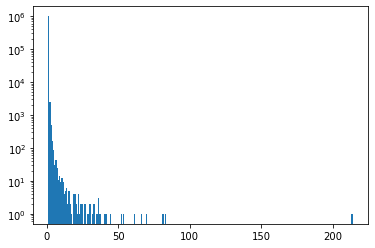

In [14]:
plt.hist(sparsecast[i].ravel(),256)
plt.yscale('log')

In [7]:
inputs.min(), inputs.max()

(0.0, 25.5)

In [8]:
 model.scaler(model.input_data)

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8), 0.0, 25.5)

In [11]:
sparsecast[3].max()

87.09635899560806